<a href="https://colab.research.google.com/github/OM-VIT/Python-ML-DL-Notebooks/blob/main/Phishing_Website_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install selenium

In [ ]:
import pandas as pd # use for data manipulation and analysis
import numpy as np # use for multi-dimensional array and matrix

import seaborn as sns # use for high-level interface for drawing attractive and informative statistical graphics 
import matplotlib.pyplot as plt # It provides an object-oriented API for embedding plots into applications
%matplotlib inline 
# It sets the backend of matplotlib to the 'inline' backend:
import time # calculate 

from sklearn.linear_model import LogisticRegression # algo use to predict good or bad
from sklearn.naive_bayes import MultinomialNB # nlp algo use to predict good or bad

from sklearn.model_selection import train_test_split # spliting the data between feature and target
from sklearn.metrics import classification_report # gives whole report about metrics (e.g, recall,precision,f1_score,c_m)
from sklearn.metrics import confusion_matrix # gives info about actual and predict
from nltk.tokenize import RegexpTokenizer # regexp tokenizers use to split words from text  
from nltk.stem.snowball import SnowballStemmer # stemmes words
from sklearn.feature_extraction.text import CountVectorizer # create sparse matrix of words using regexptokenizes  
from sklearn.pipeline import make_pipeline # use for combining all prerocessors techniuqes and algos

from PIL import Image # getting images in notebook
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator# creates words colud

from bs4 import BeautifulSoup # use for scraping the data from website
from selenium import webdriver # use for automation chrome 
import networkx as nx # for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

import pickle# use to dump model 

import warnings # ignores pink warnings 
warnings.filterwarnings('ignore')
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer


Did some surfing and found some websites offering malicious links. And found some datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loading the dataset
phish_data = pd.read_csv('/content/drive/MyDrive/Credit Card Fraud Detection/phishing_site_urls.csv')

In [ ]:
phish_data.head()


,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [ ]:
phish_data.tail()


,URL,Label
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad
549345,apple-search.info,bad


In [ ]:
phish_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


About dataset
Data is containg 5,49,346 unique entries.
There are two columns.
Label column is prediction col which has 2 categories A. Good - which means the urls is not containing malicious stuff and this site is not a Phishing Site. B. Bad - which means the urls contains malicious stuffs and this site isa Phishing Site.
There is no missing value in the dataset.





In [ ]:
phish_data.isnull().sum() # there is no missing values


URL      0
Label    0
dtype: int64

Since it is classification problems so let's see the classes are balanced or imbalances


In [ ]:
#create a dataframe of classes counts
label_counts = pd.DataFrame(phish_data.Label.value_counts())

In [ ]:
#visualizing target_col
fig = px.bar(label_counts, x=label_counts.index, y=label_counts.Label)
fig.show()

Preprocessing
Now that we have the data, we have to vectorize our URLs. I used CountVectorizer and gather words using tokenizer, since there are words in urls that are more important than other words e.g ‘virus’, ‘.exe’ ,’.dat’ etc. Lets convert the URLs into a vector form.

RegexpTokenizer
A tokenizer that splits a string using a regular expression, which matches either the tokens or the separators between tokens.

In [ ]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')#to getting alpha only


In [ ]:
phish_data.URL[0]


'nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526'

In [ ]:
# this will be pull letter which matches to expression
tokenizer.tokenize(phish_data.URL[0]) # using first row

['nobell',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'SkyPe',
 'com',
 'en',
 'cgi',
 'bin',
 'verification',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php',
 'cmd',
 'profile',
 'ach',
 'outdated',
 'page',
 'tmpl',
 'p',
 'gen',
 'failed',
 'to',
 'load',
 'nav',
 'login',
 'access']

In [ ]:
print('Getting words tokenized ...')
t0= time.perf_counter()
phish_data['text_tokenized'] = phish_data.URL.map(lambda t: tokenizer.tokenize(t)) # doing with all rows
t1 = time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words tokenized ...
Time taken 2.6886882940000305 sec


In [ ]:
phish_data.sample(5)


,URL,Label,text_tokenized
63683,www.rtd-net.de/zuse-network.html,good,"[www, rtd, net, de, zuse, network, html]"
294358,boomerandecho.com/redeeming-your-aeroplan-miles/,good,"[boomerandecho, com, redeeming, your, aeroplan..."
351324,highbeam.com/doc/1G2-3069400029.html,good,"[highbeam, com, doc, G, html]"
504992,reuters-press.com/,bad,"[reuters, press, com]"
509121,strongaliar.pro/rss/feed/stream,bad,"[strongaliar, pro, rss, feed, stream]"


SnowballStemmer
Snowball is a small string processing language, gives root words

In [ ]:
stemmer = SnowballStemmer("english") # choose a language

In [ ]:
print('Getting words stemmed ...')
t0= time.perf_counter()
phish_data['text_stemmed'] = phish_data['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words stemmed ...
Time taken 73.52908675799995 sec


In [ ]:
phish_data.sample(5)


,URL,Label,text_tokenized,text_stemmed
237964,seattletimes.nwsource.com/html/businesstechnol...,good,"[seattletimes, nwsource, com, html, businesste...","[seattletim, nwsourc, com, html, businesstechn..."
396469,mylife.com/cfox01,good,"[mylife, com, cfox]","[mylif, com, cfox]"
410116,openartcollection.com/-/s/?s=tob&t=browse,good,"[openartcollection, com, s, s, tob, t, browse]","[openartcollect, com, s, s, tob, t, brows]"
162989,daily.phanaticmag.com/2010/08/us-mens-national...,good,"[daily, phanaticmag, com, us, mens, national, ...","[daili, phanaticmag, com, us, men, nation, soc..."
265023,192.com/atoz/people/macfarlane/jamie/,good,"[com, atoz, people, macfarlane, jamie]","[com, atoz, peopl, macfarlan, jami]"


In [ ]:
print('Getting joiningwords ...')
t0= time.perf_counter()
phish_data['text_sent'] = phish_data['text_stemmed'].map(lambda l: ' '.join(l))
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting joiningwords ...
Time taken 0.2681143019999581 sec


In [ ]:
phish_data.sample(5)


,URL,Label,text_tokenized,text_stemmed,text_sent
58976,media.cs.ohio.edu/home.html,good,"[media, cs, ohio, edu, home, html]","[media, cs, ohio, edu, home, html]",media cs ohio edu home html
426401,rydercup.com/2008/europe/history/all_time_reco...,good,"[rydercup, com, europe, history, all, time, re...","[rydercup, com, europ, histori, all, time, rec...",rydercup com europ histori all time record html
53150,en.wikipedia.org/wiki/In-N-Out_Burger,good,"[en, wikipedia, org, wiki, In, N, Out, Burger]","[en, wikipedia, org, wiki, in, n, out, burger]",en wikipedia org wiki in n out burger
99169,uk.paypal.co.uk.rghuxleyjewellers.com/mpp/,bad,"[uk, paypal, co, uk, rghuxleyjewellers, com, mpp]","[uk, paypal, co, uk, rghuxleyjewel, com, mpp]",uk paypal co uk rghuxleyjewel com mpp
296772,busbymfg.com/,good,"[busbymfg, com]","[busbymfg, com]",busbymfg com


Visualization
1. Visualize some important keys using word cloud

In [ ]:
#sliceing classes
bad_sites = phish_data[phish_data.Label == 'bad']
good_sites = phish_data[phish_data.Label == 'good']

In [ ]:
bad_sites.head()


,URL,Label,text_tokenized,text_stemmed,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [ ]:
good_sites.head()


,URL,Label,text_tokenized,text_stemmed,text_sent
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag as vie i cf b vc f d b g sd v...


create a function to visualize the important keys from url


In [ ]:
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'com','http'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
d = '../input/masks/masks-wordclouds/'

In [ ]:
data = good_sites.text_sent
data.reset_index(drop=True, inplace=True)

Creating Model
CountVectorizer
CountVectorizer is used to transform a corpora of text to a vector of term / token counts.

In [ ]:
#create cv object
cv = CountVectorizer()


In [ ]:
help(CountVectorizer())

Help on CountVectorizer in module sklearn.feature_extraction.text object:

class CountVectorizer(_VectorizerMixin, sklearn.base.BaseEstimator)
 |  CountVectorizer(*, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern='(?u)\\b\\w\\w+\\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'>)
 |  
 |  Convert a collection of text documents to a matrix of token counts.
 |  
 |  This implementation produces a sparse representation of the counts using
 |  scipy.sparse.csr_matrix.
 |  
 |  If you do not provide an a-priori dictionary and you do not use an analyzer
 |  that does some kind of feature selection then the number of features will
 |  be equal to the vocabulary size found by analyzing the data.
 |  
 |  Read more in the :ref:`User Guide <text_feature_extraction>`.
 |  
 |  Parameters
 |  ----

In [ ]:
feature = cv.fit_transform(phish_data.text_sent) #transform all text which we tokenize and stemed

In [ ]:
feature[:5].toarray() # convert sparse matrix into array to print transformed features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

* Spliting the data¶

In [ ]:
trainX, testX, trainY, testY = train_test_split(feature, phish_data.Label)

LogisticRegression
Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

In [ ]:
# create lr object
lr = LogisticRegression()

In [ ]:
lr.fit(trainX,trainY)

LogisticRegression()

In [ ]:
lr.score(testX,testY)

0.9637970830875875

In [ ]:
Scores_ml = {}
Scores_ml['Logistic Regression'] = np.round(lr.score(testX,testY),2)

Training Accuracy : 0.9773767077903638
Testing Accuracy : 0.9637970830875875

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.97      0.93     36588
        Good       0.99      0.96      0.98    100749

    accuracy                           0.96    137337
   macro avg       0.95      0.96      0.95    137337
weighted avg       0.97      0.96      0.96    137337


CONFUSION MATRIX


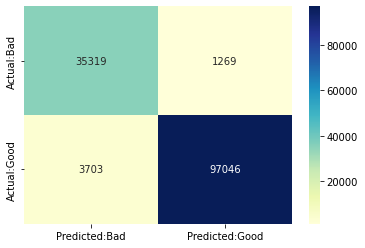

In [ ]:
print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(lr.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [ ]:
prediction=lr.predict(testX)

NameError: ignored

NameError: ignored

MultinomialNB
Applying Multinomial Naive Bayes to NLP Problems. Naive Bayes Classifier Algorithm is a family of probabilistic algorithms based on applying Bayes' theorem with the “naive” assumption of conditional independence between every pair of a feature.

In [ ]:
# create mnb object
mnb = MultinomialNB()

In [ ]:
mnb.fit(trainX,trainY)

In [ ]:
mnb.score(testX,testY)

* MultinomialNB gives us 95% accuracy

In [ ]:
Scores_ml['MultinomialNB'] = np.round(mnb.score(testX,testY),2)

In [ ]:
print('Training Accuracy :',mnb.score(trainX,trainY))
print('Testing Accuracy :',mnb.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(mnb.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(mnb.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [ ]:
acc = pd.DataFrame.from_dict(Scores_ml,orient = 'index',columns=['Accuracy'])
sns.set_style('darkgrid')
sns.barplot(acc.index,acc.Accuracy)

* So, Logistic Regression is the best fit model, Now we make sklearn pipeline using Logistic Regression

In [ ]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression())
##(r'\b(?:http|ftp)s?://\S*\w|\w+|[^\w\s]+') ([a-zA-Z]+)([0-9]+)  -- these tolenizers giving me low accuray 

In [ ]:
trainX, testX, trainY, testY = train_test_split(phish_data.URL, phish_data.Label)

In [ ]:
pipeline_ls.fit(trainX,trainY)

In [ ]:
pipeline_ls.score(testX,testY) 

In [ ]:
print('Training Accuracy :',pipeline_ls.score(trainX,trainY))
print('Testing Accuracy :',pipeline_ls.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [ ]:
pickle.dump(pipeline_ls,open('phishing.pkl','wb'))

In [ ]:
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)

In [ ]:
predict_good = ['tubemoviez.exe']
predict_bad = ['youtube.com/']
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
#predict_bad = vectorizers.transform(predict_bad)
# predict_good = vectorizer.transform(predict_good)
result = loaded_model.predict(predict_bad)
result2 = loaded_model.predict(predict_good)
print(result)
print("*"*30)
print(result2)